In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from a3_utils import draw_line

# Exercise 1

a) MISSING - CHANGE VARS!, GLOBALIZE 300 

b)

In [2]:
def gauss(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
    g /= g.sum()
    return g.reshape((-1, 1)), x

In [3]:
def gaussdx(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = -1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
    g /= np.abs(g).sum()
    return g.reshape((-1, 1)), x

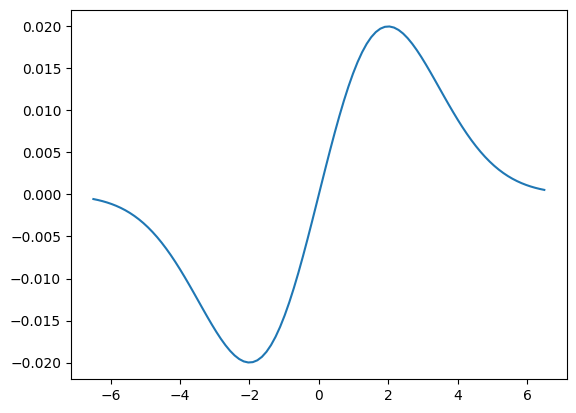

In [4]:
g, x = gaussdx(2, 100)
plt.plot(x, g)

c)

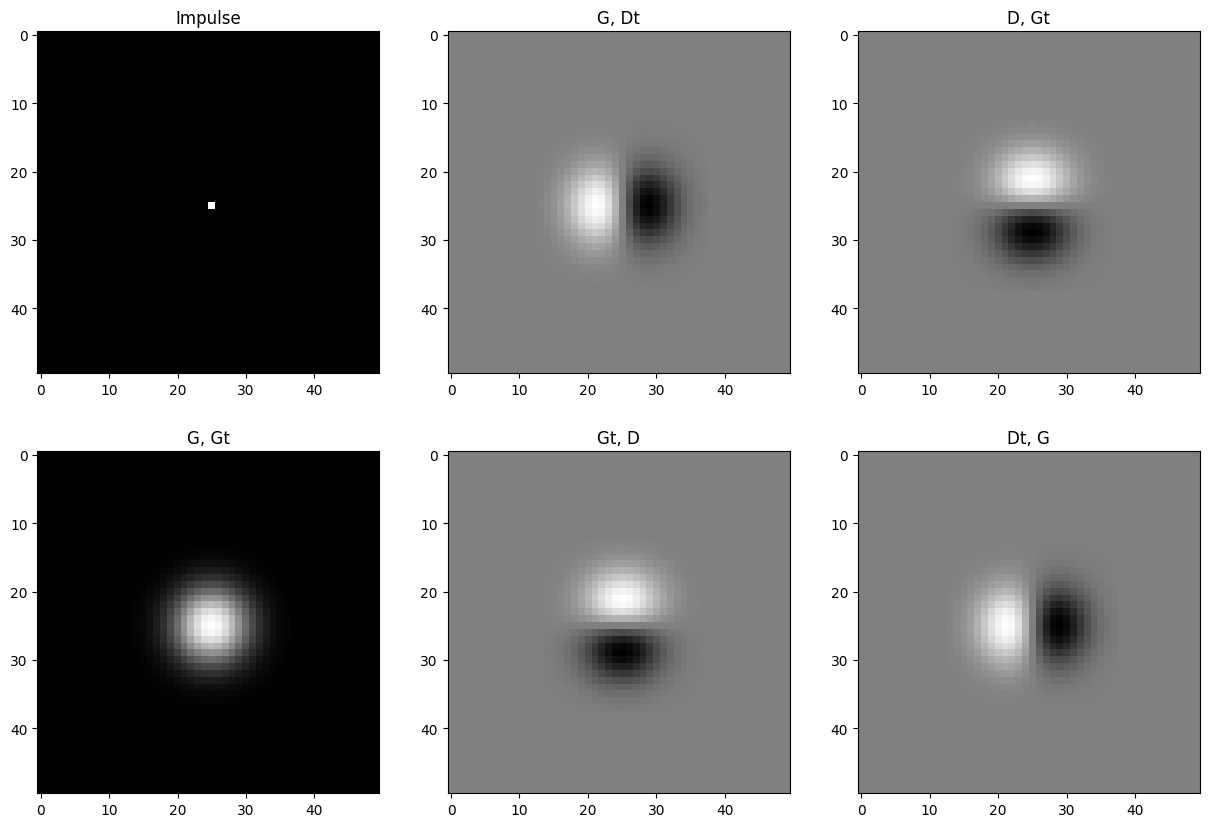

In [5]:
impulse = np.zeros((50,50))
impulse[25,25]=1

G, _ = gauss(4, 25)
DG, _ = gaussdx(4, 25)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1, title="Impulse")
plt.imshow(impulse, cmap='gray')
plt.subplot(2, 3, 2, title="G, Dt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, DG.T), cmap='gray')
plt.subplot(2, 3, 3, title="D, Gt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, DG), -1, G.T), cmap='gray')
plt.subplot(2, 3, 4, title="G, Gt")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, G.T), cmap='gray')
plt.subplot(2, 3, 5, title="Gt, D")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, G.T), -1, DG), cmap='gray')
plt.subplot(2, 3, 6, title="Dt, G")
plt.imshow(cv2.filter2D(cv2.filter2D(impulse, -1, DG.T), -1, G), cmap='gray')

d)

In [6]:
def gradient_magnitude(I_x, I_y):
    mag = np.sqrt(I_x**2 + I_y**2)
    dir = np.arctan2(I_y, I_x)
    return mag, dir

(<Axes: title={'center': 'I_dir'}>,
 <matplotlib.image.AxesImage at 0x11e77e550>)

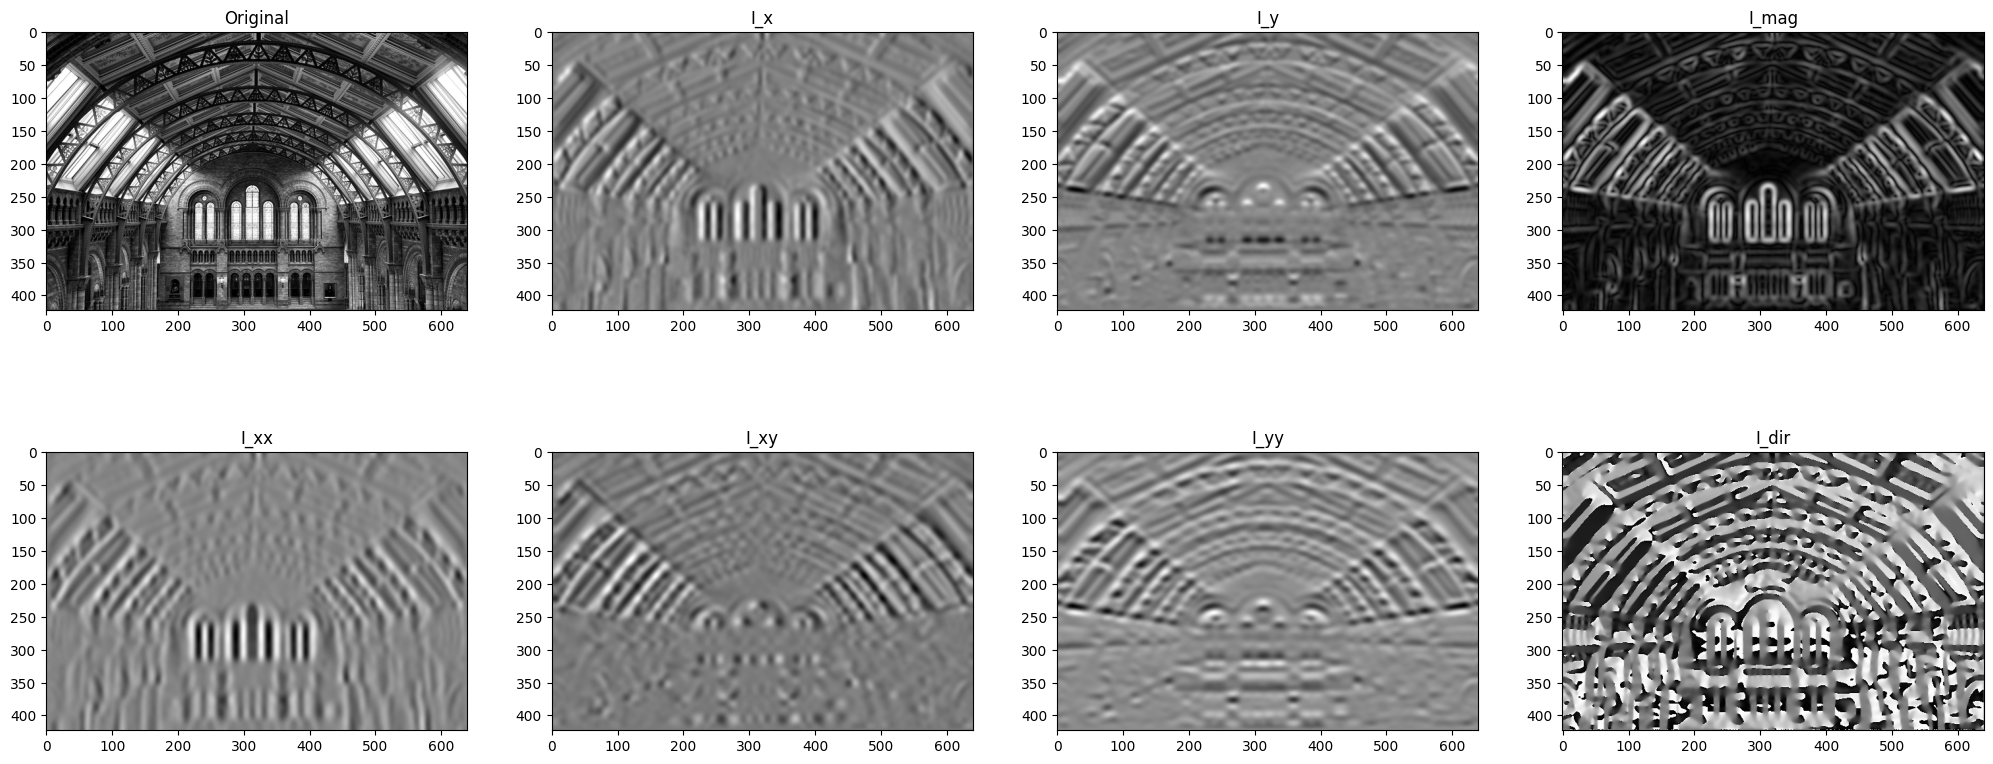

In [7]:
museum = cv2.cvtColor(cv2.imread('images/museum.jpg'), cv2.COLOR_BGR2RGB)
museum_gray = cv2.cvtColor(museum, cv2.COLOR_RGB2GRAY).astype('float64')

museum_x = cv2.filter2D(cv2.filter2D(museum_gray, -1, DG.T), -1, G)
museum_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, DG)
museum_xx = cv2.filter2D(cv2.filter2D(museum_x, -1, DG.T), -1, G)
museum_yy = cv2.filter2D(cv2.filter2D(museum_y, -1, G.T), -1, DG)
museum_xy = cv2.filter2D(cv2.filter2D(museum_x, -1, G.T), -1, DG)

museum_mag, museum_dir = gradient_magnitude(museum_x, museum_y)

plt.figure(figsize=(25, 10))
plt.subplot(2, 4, 1, title="Original")
plt.imshow(museum_gray, cmap='gray')
plt.subplot(2, 4, 2, title="I_x")
plt.imshow(museum_x, cmap='gray')
plt.subplot(2, 4, 3, title="I_y")
plt.imshow(museum_y, cmap='gray')
plt.subplot(2, 4, 4, title="I_mag")
plt.imshow(museum_mag, cmap='gray')
plt.subplot(2, 4, 5, title="I_xx"), plt.imshow(museum_xx, cmap='gray')
plt.subplot(2, 4, 6, title="I_xy"), plt.imshow(museum_xy, cmap='gray')
plt.subplot(2, 4, 7, title="I_yy"), plt.imshow(museum_yy, cmap='gray')
plt.subplot(2, 4, 8, title="I_dir"), plt.imshow(museum_dir, cmap='gray')

# Exercise 2

a)

In [8]:
def findedges(I, sigma, theta):
    G, _ = gauss(sigma, 2*math.ceil(sigma*3)+1)
    D, _ = gaussdx(sigma, 2*math.ceil(sigma*3)+1)
    I_x= cv2.filter2D(cv2.filter2D(museum_gray, -1, D.T), -1, G)
    I_y = cv2.filter2D(cv2.filter2D(museum_gray, -1, G.T), -1, D)
    mag, _ = gradient_magnitude(I_x, I_y)
    I_e = np.where(mag > theta, 1, 0)
    return I_e

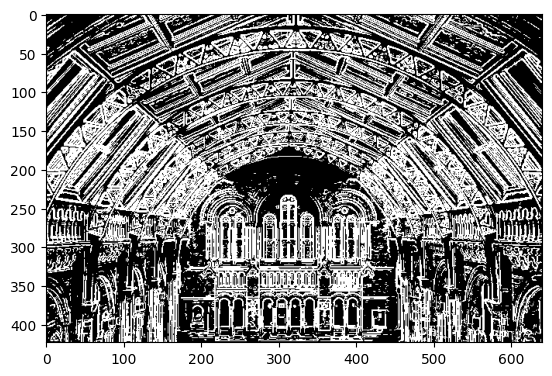

In [9]:
museum_edges = findedges(museum_gray, 1, 15)

plt.imshow(museum_edges, cmap='gray')

b)

In [10]:
def nonmaxima_suppression(img_mag, img_dir):
    res = img_mag.copy()

    for y in range(1, img_mag.shape[0]-1):
        for x in range(1, img_mag.shape[1]-1):
            fi = img_dir[y,x] % np.pi
            
            # right
            if (0 <= fi and fi < np.pi/4):
                if img_mag[y,x] < img_mag[y, x-1] or img_mag[y,x] < img_mag[y, x+1]:
                    res[y,x] = 0
            # right up
            if (np.pi/4 <= fi and fi < np.pi/2):
                if img_mag[y,x] < img_mag[y-1, x-1] or img_mag[y,x] < img_mag[y+1, x+1]:
                    res[y,x] = 0
            # up
            if (np.pi/2 <= fi and fi < 3*np.pi/4): # |
                if img_mag[y,x] < img_mag[y-1, x] or img_mag[y,x] < img_mag[y+1, x]:
                    res[y,x] = 0
            # left up
            if (3*np.pi/4 <= fi and fi < np.pi): # \
                if img_mag[y,x] < img_mag[y+1, x-1] or img_mag[y,x] < img_mag[y-1, x+1]:
                    res[y,x] = 0
                
    return res

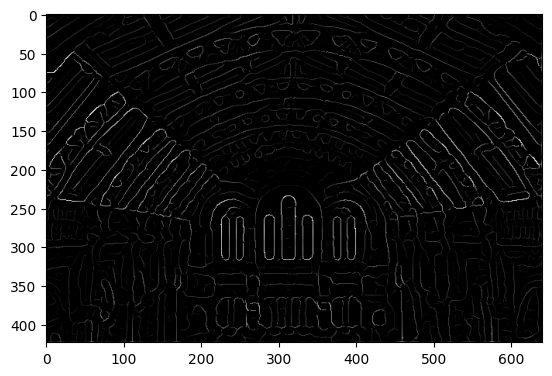

In [11]:
museum_suppressed = nonmaxima_suppression(museum_mag, museum_dir)

plt.imshow(museum_suppressed, cmap='gray')

# Exercise 3

Q: missing

a)

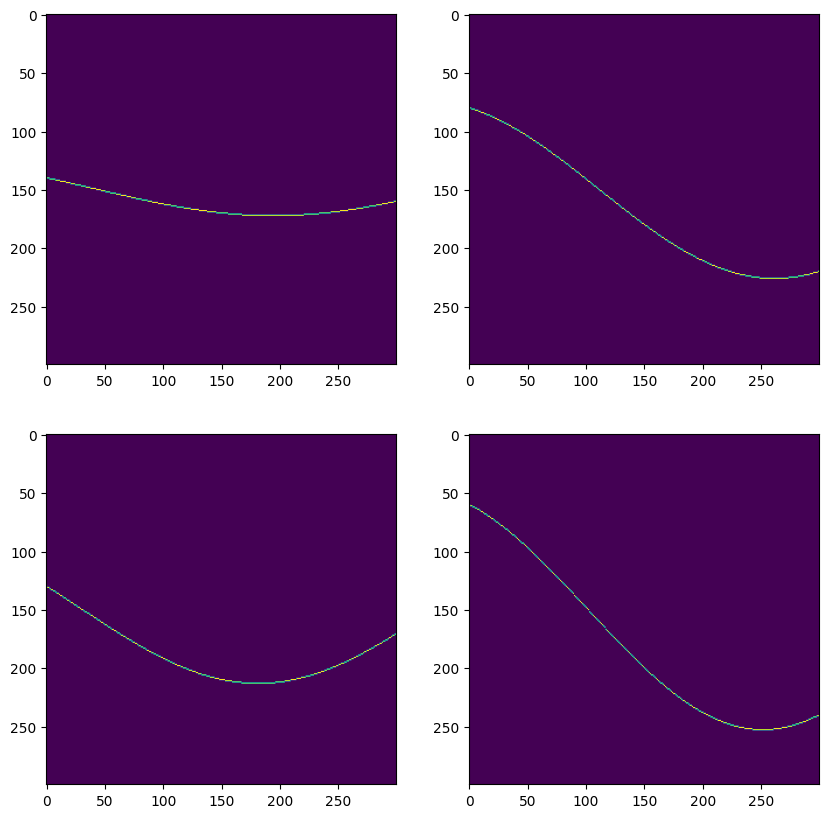

In [12]:
points = [(20, 10), (30, 70), (60, 20), (50, 90)]

plt.figure(figsize=(10, 10))
k = 1
for x, y in points:
    acc = np.zeros((300, 300))
    
    # we plot the sinusoid of a line over the range 300
    for i in range(300):
        # fi ranges [-pi/2, pi/2]
        fi = i/300 * np.pi - np.pi/2
        ro = x * np.cos(fi) + y * np.sin(fi)
        j = round(ro) + 150
        if j < 0 or j >= 300:
            continue
    
        acc[j][i]+=1

    plt.subplot(2, 2, k)
    plt.imshow(acc, cmap='viridis')
    
    k += 1

b)

In [13]:
def hough_find_lines(img, theta_bins, rho_bins):
    acc = np.zeros((rho_bins, theta_bins))
    
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y][x] >= 1:
                for i in range(theta_bins):
                    # theta goes [-pi/2, pi/2]
                    theta = i/theta_bins * np.pi - np.pi/2
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    # ro goes from [-D, D]
                    j = round((rho + D) / (2*D) * rho_bins)
                    if j < 0 or j >= rho_bins:
                        continue
                    acc[j][i] += 1
    return acc

uint8
uint8


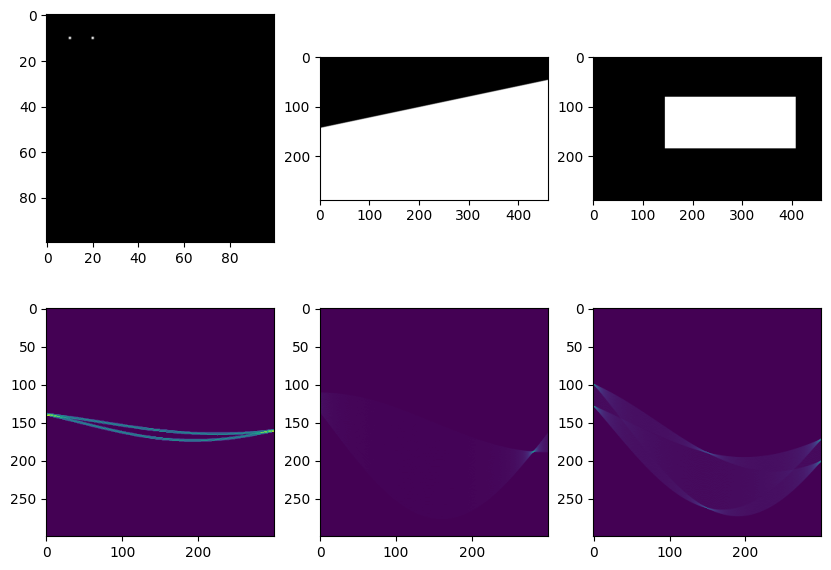

In [76]:
syntethic = np.zeros((100, 100)).astype('uint8')
syntethic[10, 10] = 255
syntethic[10, 20] = 255
oneline = cv2.cvtColor(cv2.imread('images/oneline.png'), cv2.COLOR_BGR2GRAY)
rectangle = cv2.cvtColor(cv2.imread('images/rectangle.png'), cv2.COLOR_BGR2GRAY)

syntethic_edges = cv2.Canny(syntethic, threshold1=100, threshold2=200)
rectangle_edges = cv2.Canny(rectangle, threshold1=100, threshold2=200)
oneline_edges = cv2.Canny(oneline, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 7))
plt.subplot(2, 3, 1)
plt.imshow(syntethic, cmap='gray')
plt.subplot(2, 3, 2)
plt.imshow(oneline, cmap='gray')
plt.subplot(2, 3, 3)
plt.imshow(rectangle, cmap='gray')

plt.subplot(2, 3, 4)
plt.imshow(hough_find_lines(syntethic_edges, 300, 300), cmap='viridis')
plt.subplot(2, 3, 5)
plt.imshow(hough_find_lines(oneline_edges, 300, 300), cmap='viridis')
plt.subplot(2, 3, 6)
plt.imshow(hough_find_lines(rectangle_edges, 300, 300), cmap='viridis')

c)

In [77]:
# suppresses pixels (lines) if they are not maxima of their neighbours
def nonmaxima_suppression_box(img):
    res = img.copy()
    
    for y in range(img.shape[1]):
        for x in range(img.shape[0]):
            neighbourhood = [(y + i, x + j) for i in range(-1, 2) for j in range(-1, 2)]
            
            for u, v in neighbourhood:
                if u < 0 or v < 0 or u >= img.shape[1] or v >= img.shape[0]:
                    continue
                # suppress non-maximums
                if img[y, x] < img[u, v]:
                    res[y, x] = 0
    return res

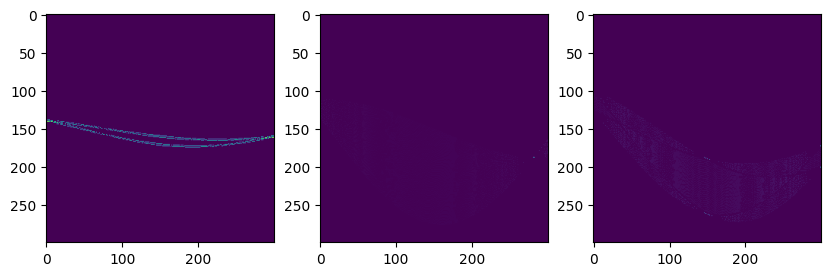

In [78]:
syntethic_suppressed = nonmaxima_suppression_box(hough_find_lines(syntethic_edges, 300, 300))
oneline_suppressed = nonmaxima_suppression_box(hough_find_lines(oneline_edges, 300, 300))
rectangle_suppressed = nonmaxima_suppression_box(hough_find_lines(rectangle_edges, 300, 300))

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(syntethic_suppressed, cmap='viridis')
plt.subplot(1, 3, 2)
plt.imshow(oneline_suppressed, cmap='viridis')
plt.subplot(1, 3, 3)
plt.imshow(rectangle_suppressed, cmap='viridis')

d)

In [90]:
def draw_image_with_lines(img, acc_bin):
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    for j, i in np.argwhere(acc_bin):
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    plt.imshow(img, cmap='gray')

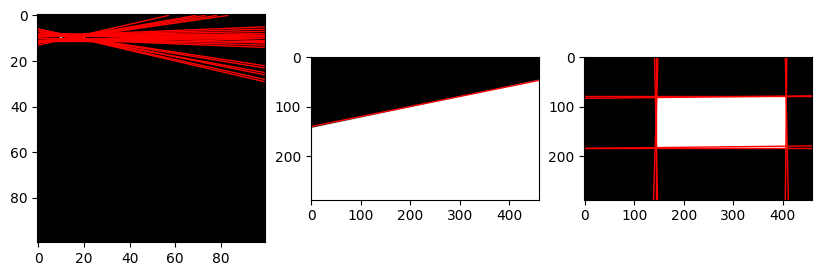

In [91]:
threshold1 = 6
threshold2 = 100
threshold3 = 100

syntethic_bin = np.where(syntethic_suppressed < threshold1, 0, 1)
oneline_bin = np.where(oneline_suppressed < threshold2, 0, 1)
rectangle_bin = np.where(rectangle_suppressed < threshold3, 0, 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
draw_image_with_lines(syntethic, syntethic_bin)
plt.subplot(1, 3, 2)
draw_image_with_lines(oneline, oneline_bin)
plt.subplot(1, 3, 3)
draw_image_with_lines(rectangle, rectangle_bin)

e)

In [111]:
def show_lines(img, subplot):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    img_edges = cv2.Canny(img_gray, 100, 200)    
    img_acc = hough_find_lines(img_edges, 300, 300)    
    
    plt.subplot(2, 2, subplot)
    plt.imshow(img_acc)

    img_acc_s = nonmaxima_suppression_box(img_acc)
    D = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    
    N = 10
    acc_sorted = np.unravel_index(np.argsort(img_acc_s, axis=None)[-N:], img_acc_s.shape)

    plt.subplot(2, 2, subplot + 1)
    for k in range(N):
        j, i = acc_sorted[0][k], acc_sorted[1][k]
        rho = (2*D*j)/300 - D
        theta = i/300 * np.pi - np.pi/2
        draw_line(rho, theta, img.shape[0], img.shape[1])
    
    plt.imshow(img)
    

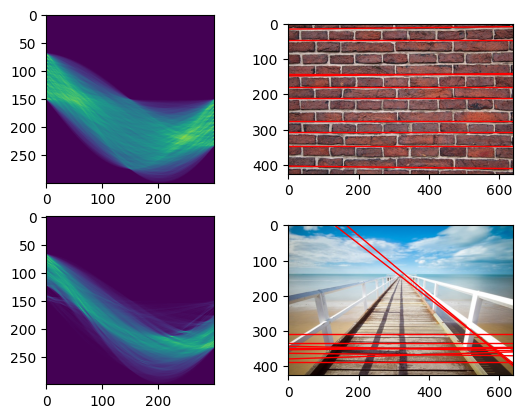

In [112]:
bricks = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB)
show_lines(bricks, 1)

pier = cv2.cvtColor(cv2.imread('images/pier.jpg'), cv2.COLOR_BGR2RGB)
show_lines(pier, 3)